In [1]:
import random
import pickle
import sys
import os
import time
import numpy as np
from numpy.random import Generator, PCG64
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Racetrack problem
## solved with temporal difference instead of Monte Carlo

Exercise 5.12: Racetrack (programming) Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run o↵ the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by +1, 1, or 0 in each step, for a total of nine (3 X 3) actions. Both velocity components are restricted to be nonnegative and less than 5, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are 1 for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability 0.1 at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [2]:
class progress_bar():
    def __init__(self, total, suffix = '', bar_len = 100):
        self.count = 0
        self.total = total
        self.suffix = suffix
        self.bar_len = bar_len
        self.start = time.time()
    
    def incr(self, incr=1):
        self.count += incr
        filled_len = int(round(self.bar_len * self.count / float(self.total)))
        percents = round(100.0 * self.count / float(self.total), 1)
        bar = '=' * filled_len + '-' * (self.bar_len - filled_len)
        stop = time.time()
        sys.stdout.write(f'[{bar}] {percents}% {incr/(stop-self.start):.1f} episodes/s      \r')
        self.start = stop
        sys.stdout.flush()

In [3]:
height = 100
width = 100
w=7

In [4]:
def gen_track(track, turns, w=9, seed=42, noise=12):
    rng = Generator(PCG64(seed))
    temp = track.copy()
    lx = track.shape[0]
    ly = track.shape[1]
    xs = [0]*turns+[70]
    ys = [13]+[ly-1]*(turns)
    for i in range(1, turns):
        if i ==1:
            xs[i] = xs[i-1] + 20 + lx//turns+rng.integers(-noise,noise)
        else:
            xs[i] = xs[i-1] + rng.choice([-1,1])*(lx)//(turns+1) + rng.integers(-noise,noise)
        ys[i] = ys[i-1] + (ly-20)//turns+rng.integers(-noise,noise)
    for i in range(turns):
        temp[min(xs[i],xs[i+1]):max(xs[i],xs[i+1]),ys[i]-w:ys[i]+w] = 1
        temp[xs[i+1]-w:xs[i+1]+w, ys[i]:ys[i+1]+1] = 1
    for k in range(6):
        for i in range(1,lx-1):
            for j in range(1,ly-1):
                if temp[i,j] == 0:
                    prob = temp[i-1:i+2,j-1:j+2].sum()
                    temp[i,j] = 1 if prob >=4 else 0
    return temp

In [5]:
track = np.zeros((height,width), dtype='int64')
track = gen_track(track,3)

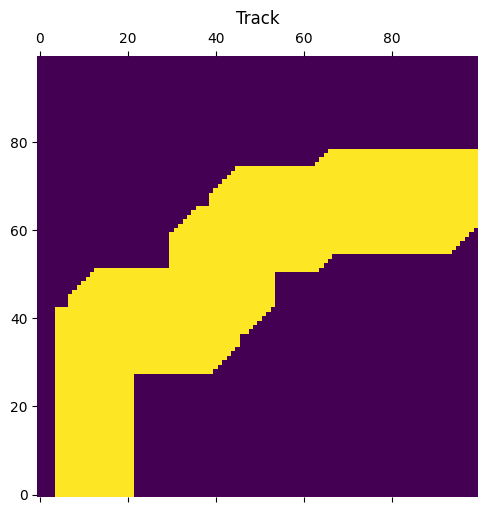

In [6]:
fig, ax = plt.subplots(nrows=1, ncols =1, figsize = (15,5))
fig.tight_layout(h_pad = 6)
#ax1.grid(axis = 'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Track')
ax.matshow(track, origin='lower')

In [7]:
class Env():
    def __init__(self, track, w=9):
        self.track = track
        self.state = [0, track[0,:].argmax() + np.random.randint(2*w),0 ,0]  # set random initial state

    def get_state(self):
        return tuple(self.state)

    def _is_out_of_track(self, new_state):
        return new_state[0] < 0 or new_state[0] >= self.track.shape[1] or new_state[1] < 0 or new_state[1] >= self.track.shape[1] or self.track[new_state] == 0

    def _is_finished(self, new_state):
        return self.track[:,self.track.shape[1]-1][new_state[0]] == 1 and new_state[1] >= self.track.shape[1]

    def step(self, action):
        x = self.state[0] + self.state[2]
        y = self.state[1] + self.state[3]
        reward = -1
        self.state[2] += action[0]
        self.state[3] += action[1]
        if self._is_finished((x,y)):
            self.state[0] = x
            self.state[1] = self.track.shape[1]-1
            return tuple(self.state), 0
        if self._is_out_of_track((x,y)):
            self.reset()
        else:
            self.state[0] = x
            self.state[1] = y
        return tuple(self.state), reward        

    def reset(self):
        self.state = [0, track[0,:].argmax() + np.random.randint(2*w),0 ,0]   # set random initial state

In [8]:
def get_possible_actions(state):
        actions = {*range(9)}
        if state[2] == 0:
            actions -= {0,1,2}
        if state[2] == 5:
            actions -= {6,7,8}
        if state[3] == 0:
            actions -= {0,3,6}
        if state[3] == 5:
            actions -= {2,5,8}
        if state[2] == 1 and state[3] == 0:
            actions -= {1}
        if state[2] == 0 and state[3] == 1:
            actions -= {3}
        return list(actions)

In [9]:
class Agent():
    def __init__(self, env, policy = {}, eps=0.1):
        self.env = env
        self.policy = policy
        self.eps = eps

    def _get_possible_actions(self):
        actions = {*range(9)}
        if self.env.state[2] == 0:
            actions -= {0,1,2}
        if self.env.state[2] == 5:
            actions -= {6,7,8}
        if self.env.state[3] == 0:
            actions -= {0,3,6}
        if self.env.state[3] == 5:
            actions -= {2,5,8}
        if self.env.state[2] == 1 and self.env.state[3] == 0:
            actions -= {1}
        if self.env.state[2] == 0 and self.env.state[3] == 1:
            actions -= {3}
        return list(actions)
    
    def get_action_target(self):  # select greed action
        action = self.policy.get(self.env.get_state(), None)
        actions = self._get_possible_actions()
        if not action:
            action = random.choice(actions)
        return action

    def get_action_behavior(self):  # select epsilon greedy action
        action = self.policy.get(self.env.get_state(), None)
        actions = self._get_possible_actions()
        if not action:
            action = random.choice(actions)
            actions.remove(action)
        if np.random.uniform() > self.eps:
            return action, 1 - self.eps
        else:
            return random.choice(actions), self.eps / len(actions)

    def simulate(self, init=None):  # use epsilon greedy policy
        self.env.reset()
        if init:
            self.env.state = init
        trajectory = []
        reward = 0
        while 1:
            action, prob = self.get_action_behavior()
            state, rew = self.env.step((action//3-1, action%3-1))
            reward += rew
            trajectory.append((state, action, rew, prob))
            if rew == 0:
                break
                
        return trajectory, reward

    def play(self, init=None):  # use greedy policy
        self.env.reset()
        if init:
            self.env.state = init
        trajectory = []
        reward = 0
        while 1:
            action = self.get_action_target()
            state, rew = self.env.step((action//3-1, action%3-1))
            reward += rew
            trajectory.append((state, action, rew))
            if rew == 0:
                break
                
        return trajectory, reward

In [10]:
def sarsa(agent, Q={}, policy={}, alpha=0.02, alpha_decay=0.9, episodes=100, gamma=0.9, init=-5):
    history = np.zeros(episodes, dtype='int64')
    bar = progress_bar(episodes)
    directory = 'data/'
    os.makedirs(directory, exist_ok = True)

    for i in range(episodes):
        agent.policy = policy
        reward = 0
        agent.env.reset()
        action, _ = agent.get_action_behavior()
        state = agent.env.get_state()
        while 1:
            new_state, rew = agent.env.step((action//3-1, action%3-1))
            new_action, _ = agent.get_action_behavior()
            reward += rew
            if Q.get(state, None) is None:
                Q[state] = np.ones(9)*init
            if Q.get(new_state, None) is None:
                if rew == 0:
                    Q[new_state] = np.zeros(9)
                else:
                    Q[new_state] = np.ones(9)*init
            Q[state][action] += alpha*(rew + gamma*Q[new_state][new_action] - Q[state][action])
            possible_actions = get_possible_actions(state)
            greedy_index = Q[state][possible_actions].argmax()
            agent.policy[state] = possible_actions[greedy_index]
            
            action = new_action
            state = new_state
            if rew==0:
                break
        history[i] = reward
        if i % (episodes//10) == 0:
            alpha *= alpha_decay  # gradually reduce learnin rate
            # save check point to file
            with open('data/Q_sarsa.pkl', 'wb') as f:
                pickle.dump(Q, f)
            with open('data/policy_sarsa.pkl', 'wb') as f:
                pickle.dump(policy, f)
            np.save('data/history_sarsa',history)
        if i % 1000 == 0:
            bar.incr(1000)

    return Q, agent.policy, history

In [11]:
def expected_sarsa(agent, Q={}, policy={}, alpha=1, episodes=100, gamma=0.95, init=-5):
    history = np.zeros(episodes, dtype='int64')
    bar = progress_bar(episodes)
    directory = 'data/'
    os.makedirs(directory, exist_ok = True)

    for i in range(episodes):
        agent.policy = policy
        reward = 0
        agent.env.reset()
        action, _ = agent.get_action_behavior()
        state = agent.env.get_state()
        while 1:
            new_state, rew = agent.env.step((action//3-1, action%3-1))
            new_action, _ = agent.get_action_behavior()
            reward += rew
            if Q.get(state, None) is None:
                Q[state] = np.ones(9)*init
            if Q.get(new_state, None) is None:
                if rew == 0:
                    Q[new_state] = np.zeros(9)
                else:
                    Q[new_state] = np.ones(9)*init
            actions = get_possible_actions(new_state)
            greedy_action = policy.get(new_state, None)
            if not greedy_action:
                prob = 1/len(actions)
            else:
                prob = 1-agent.eps
            expected = 0
            for act in actions:
                if act == greedy_action:
                    expected += prob*Q[new_state][act]
                else:
                    expected += (1-prob)/(len(actions)-1)*Q[new_state][act]
            Q[state][action] += alpha*(rew + gamma*expected - Q[state][action])
            possible_actions = get_possible_actions(state)
            greedy_index = Q[state][possible_actions].argmax()
            agent.policy[state] = possible_actions[greedy_index]
            action = new_action
            state = new_state
            if rew==0:
                break
        history[i] = reward
        if i % (episodes//10) == 0:
            # save check point to file
            with open('data/Q_expected_sarsa.pkl', 'wb') as f:
                pickle.dump(Q, f)
            with open('data/policy_expected_sarsa.pkl', 'wb') as f:
                pickle.dump(policy, f)
            np.save('data/history_expected_sarsa',history)
        if i % 1000 == 0:
            bar.incr(1000)

    return Q, agent.policy, history

In [12]:
eps = 0.1  # 0.01
alpha = 0.4  # 0.015
alpha_decay = 0.9
n_episodes = 1000000
gamma = 0.95
env = Env(track, w)
agent = Agent(env, {}, eps)

try:
    history_sarsa = np.load('data/history_sarsa.npy')
except:
    history_sarsa = None
try:
    with open('data/Q_sarsa.pkl', 'rb') as f:
        Q_sarsa = pickle.load(f) # deserialize using load()
    with open('data/policy_sarsa.pkl', 'rb') as f:
        policy_sarsa = pickle.load(f) # deserialize using load()
except:
    Q_sarsa, policy_sarsa, history_sarsa = sarsa(agent, alpha=alpha, alpha_decay=alpha_decay, episodes=n_episodes, gamma=gamma)

In [13]:
eps = 0.1  # 0.01
alpha = 1  # 0.015
alpha_decay = 1
n_episodes = 1000000
gamma = 0.95
env = Env(track, w)
agent = Agent(env, {}, eps)

try:
    history_expected_sarsa = np.load('data/history_expected_sarsa.npy')
except:
    history_expected_sarsa = None
try:
    with open('data/Q_expected_sarsa.pkl', 'rb') as f:
        Q_expected_sarsa = pickle.load(f) # deserialize using load()
    with open('data/policy_expected_sarsa.pkl', 'rb') as f:
        policy_expected_sarsa = pickle.load(f) # deserialize using load()
except:
    Q_expected_sarsa, policy_expected_sarsa, history_expected_sarsa = expected_sarsa(agent, alpha=alpha, episodes=n_episodes, gamma=gamma) 

[-0.00832849]


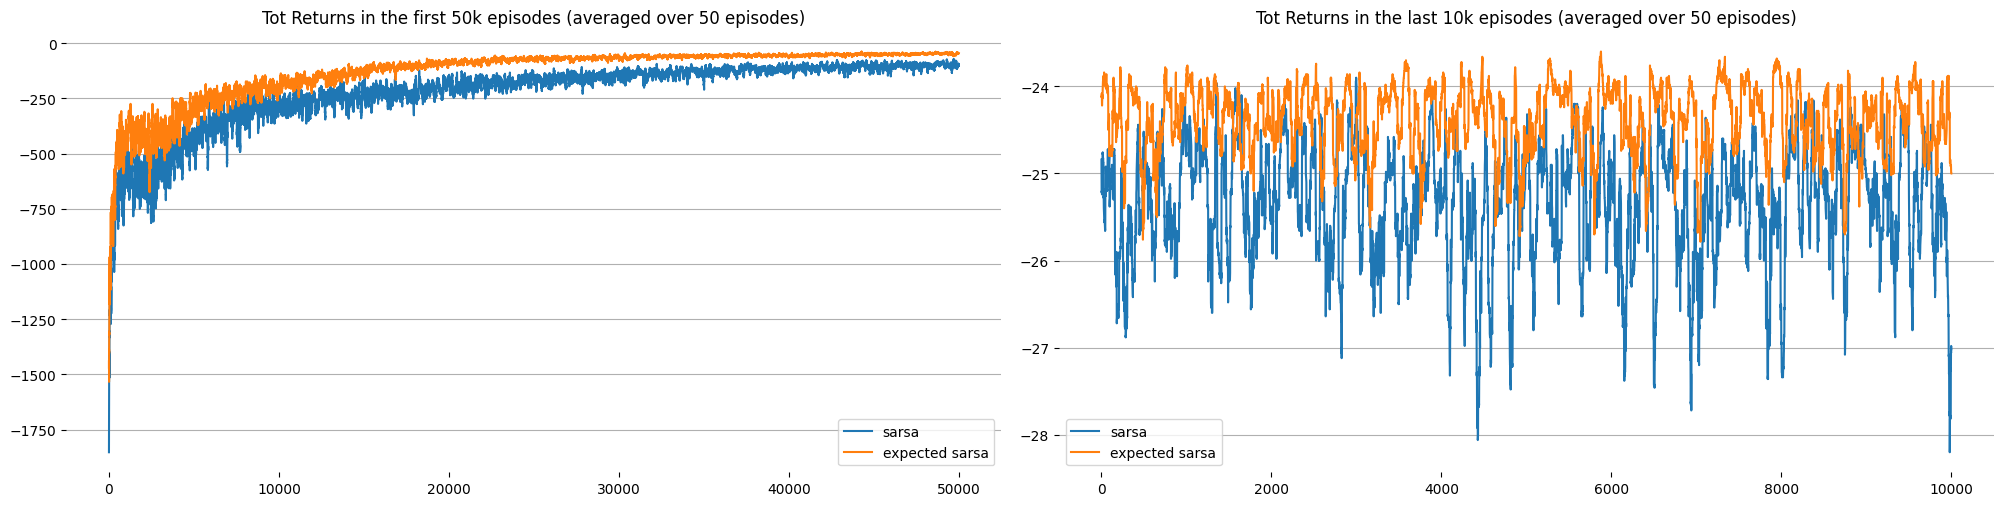

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize = (20,5))
fig.tight_layout(h_pad = 6)
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_title('Tot Returns in the first 50k episodes (averaged over 50 episodes)')
ax2.grid(axis = 'y')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_title('Tot Returns in the last 10k episodes (averaged over 50 episodes)')
conv = np.convolve(history_sarsa, np.ones(50)/50, mode='valid')
conv_e = np.convolve(history_expected_sarsa, np.ones(50)/50, mode='valid')
sns.lineplot(conv[:50000], ax=ax1, label='sarsa')
sns.lineplot(conv_e[:50000], ax=ax1, label='expected sarsa')
sns.lineplot(conv[-10000:], ax=ax2, label='sarsa')
sns.lineplot(conv_e[-10000:], ax=ax2, label='expected sarsa')
lin_reg = LinearRegression()
lin_reg.fit(np.arange(10000).reshape(-1,1), history_sarsa[-10000:])
print(lin_reg.coef_*1e3)

In [15]:
agent = Agent(env, policy_sarsa, eps)
t = agent.play([0,18,0,0])  # sample trajectory
#t = agent.play()
print(f'tot reward: {t[1]}')

tot reward: -27


In [16]:
agent = Agent(env, policy_expected_sarsa, eps)
te = agent.play([0,18,0,0])  # sample trajectory
#te = agent.play()
print(f'tot reward: {te[1]}')

tot reward: -24


In [17]:
s = t[0][:]
a = np.array([(i[0][0], i[0][1], i[1]//3-1,i[1]%3-1) for i in s])
s = np.array([i[0] for i in s])

In [18]:
se = te[0][:]
ae = np.array([(i[0][0], i[0][1], i[1]//3-1,i[1]%3-1) for i in se])
se = np.array([i[0] for i in se])

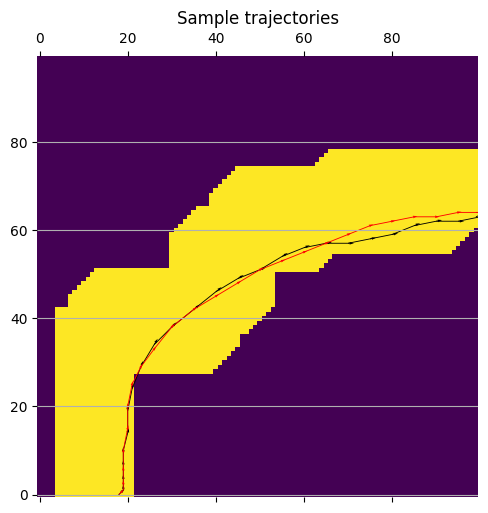

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols =1, figsize = (10,5))
fig.tight_layout(h_pad = 6)
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_title('Sample trajectories')
ax1.quiver(s[:,1], s[:,0], s[:,3], s[:,2], units='width', width=0.002)
ax1.quiver(se[:,1], se[:,0], se[:,3], se[:,2], units='width', width=0.002, color='red')
ax1.matshow(track, origin='lower')